# Tutorial 4.1 XXX
In this tutorial xxx

(ADD IMAGE)

Example in a triangle with 3 nodes
E = 1MPa
A = 0.01 m2

Terminology
NON = number of nodes
NOE = number of eleemntsa
NPE = nodes per element
ENL = Extended node list - Size of (NoN x 6*PD)
PD problem dimension

Node coordinates needed
NL_(NoN x PD) = [[0 0] [1 0] [0.5 1]]
EL_(NoE x NPE) = [[1 2] [2 3] [3 1]] -- start/end points/nodes
    ! Order does not matter


In [72]:
import numpy as np

NL = np.array([ [0, 0],
                [1, 0],
                [0.5, 1]])
EL = np.array([ [1, 2],
                [2, 3],
                [3, 1]])

Boudary conditions
Fix N1 in x and y
Fix N2 in x
Add force on node 3 (20 N)

! Value of 1 for free, -1 for fixed
Than manually input beginning Forces and Displacements

In [73]:
DorN = np.array([[-1,-1],
                 [1,-1],
                 [1,1]])
Fu = np.array([[0,0],
               [0,0],
               [0,-20]])
Uu = np.array([[0,0],
               [0,0],
               [0,0]])

In [74]:
# Constants (From before)
E = 10**6
A = 0.01

PD = np.size(NL, 1) # 2 columns for this 2D problem
NoN = np.size(NL, 0)

# Initialize and build extended node list ENL
ENL = np.zeros([NoN, 6*PD]) # initialize
ENL[:,0:PD] = NL[:,:]       # first 2 columns get node list
ENL[:,PD:2*PD] = DorN[:,:]  # column 3 and 4 get boundary conditions


In [75]:
# Boundary condition expansion
def assign_BCs(NL, ENL):

    PD = np.size(NL, 1)
    NoN = np.size(NL, 0)

    DOFs = 0
    DOCs = 0

    # Local DOF
    for i in range(0, NoN): # loop over nodes
        for j in range(0, PD): # loop over columns (meaning degrees of freedom, here 2 columns)
            if ENL[i,PD+j] == -1: # if diriclet node
                # PD+j accesses column 3 or 4 here
                DOCs -= 1
                ENL[i,2*PD+j] = DOCs
            else: # if neumann node
                DOFs += 1
                ENL[i, 2*PD+j] = DOFs
    # Global DOF
    for i in range(0, NoN):
        for j in range(0, PD):
            if ENL[i,2*PD+j] < 0:
                ENL[i,3*PD+j] = abs(ENL[i,2*PD+j]) + DOFs
            else:
                ENL[i,3*PD+j] = abs(ENL[i,2*PD+j])
    
    DOCs = abs(DOCs)

    return (ENL, DOFs, DOCs)
        
(ENL, DOFs, DOCs) = assign_BCs(NL,ENL)

In [76]:
# Stiffness assignment

def element_stiffness(nl, ENL, E, A):
    
    # Get coordinates
    # nl[0] takes the node, but these are counted from 1, 
    # so we need to substract to get the "first" index, which is 0
    X1 = ENL[nl[0]-1, 0]
    Y1 = ENL[nl[0]-1, 1]
    X2 = ENL[nl[1]-1, 0]
    Y2 = ENL[nl[1]-1, 1]

    # element length
    L = np.sqrt((X1-X2)**2 + (Y1-Y2)**2)

    # element directions ~ cosines and sines
    C = (X2-X1)/L
    S = (Y2-Y1)/L

    k = E*A/L * np.array([[C*C, C*S, -C*C, -C*S],
                          [C*S, S*S, -C*S, -S*S],
                          [-C*C, -C*S, C*C, C*S],
                          [-C*S, -S*S, C*S, S*S],])
    
    return k


def assemble_stiffness(ENL, EL, NL, E, A):

    # dim(K) = (NoN*PD x NoN*PD) so here 6x6

    NoE = np.size(EL, 0) # will give 3 here
    NPE = np.size(EL, 1) # will give 2
    PD = np.size(NL, 1)
    NoN = np.size(NL, 0)

    K = np.zeros([NoN*PD, NoN*PD])
    # element stiffness -- then add to global matrix
    for i in range(0,NoE):
        nl = EL[i,0:NPE] # nodes around this element
        k = element_stiffness(nl, ENL,E,A)
        for r in range(0, NPE): # loop over elements
            for p in range(0, PD): # loop over dimensions ~ x and y
                for q in range(0,NPE):
                    for s in range(0,PD):
                        row = ENL[nl[r]-1, p+3*PD]
                        column = ENL[nl[q]-1, s+3*PD]
                        value = k[r*PD+p, q*PD+s]
                        K[int(row)-1,int(column)-1] += value
    
    return K

K = assemble_stiffness(ENL,EL, NL,E,A)

In [77]:
# Further ENL update with displacements and forces

ENL[:,4*PD:5*PD] = Uu[:,:] # column 8 and 9
ENL[:,5*PD:6*PD] = Fu[:,:] # clumn 10 and 11

In [78]:
# Now fill in the question marks

# Flatten Uu and Fu for later use
Uu = Uu.flatten()
Fu = Fu.flatten()

# Find forces and displacements

def assemble_forces(ENL, NL):
    
    PD = np.size(NL, 1)
    NoN = np.size(NL, 0)
    DOF = 0

    Fp = []
    for i in range(0, NoN):
        for j in range(0, PD):
            if ENL[i,PD+j] == 1: # if fixed node
                DOF += 1
                Fp.append(ENL[i,5*PD+j]) 
    Fp = np.vstack([Fp]).reshape(-1,1)
    return Fp

def assemble_displacement(ENL, NL):
    
    PD = np.size(NL, 1)
    NoN = np.size(NL, 0)
    DOC = 0

    Up = []
    for i in range(0, NoN):
        for j in range(0, PD):
            if ENL[i,PD+j] == 1: # if fixed node
                DOC += 1
                Up.append(ENL[i,4*PD+j]) 
    Up = np.vstack([Up]).reshape(-1,1)
    return Up

Fp = assemble_forces(ENL, NL)
Up = assemble_displacement(ENL, NL)

In [79]:
# The real physics 

K_UU = K[0:DOFs,0:DOFs]
K_UP = K[0:DOFs,DOFs:DOFs+DOCs]
K_PU = K[DOFs:DOFs+DOCs,0:DOFs]
K_PP = K[DOFs:DOFs+DOCs,DOFs:DOFs+DOCs]

F = Fp - np.matmul(K_UP, Up)
Uu = np.matmul(np.linalg.inv(K_UU),F)
Fu = np.matmul(K_PU, Uu) + np.matmul(K_PP, Up)

In [80]:
# Update ENL now

def update_nodes(ENL, Uu, NL, Fu):

    PD = np.size(NL, 1)
    NoN = np.size(NL, 0)

    DOFs = 0
    DOCs = 0
    for i in range(0, NoN):
        for j in range(0, PD):
            if ENL[i,PD+j] == 1:
                DOFs += 1
                ENL[i,4*PD+j] = Uu[DOFs-1] # update the displacement
            else:
                DOCs += 1
                ENL[i,5*PD+j] = Fu[DOCs-1]

    return ENL


ENL = update_nodes(ENL, Uu, NL, Fu)

In [81]:
np.around(ENL,4)

array([[ 0.0e+00,  0.0e+00, -1.0e+00, -1.0e+00, -1.0e+00, -2.0e+00,
         4.0e+00,  5.0e+00,  0.0e+00,  0.0e+00, -0.0e+00,  1.0e+01],
       [ 1.0e+00,  0.0e+00,  1.0e+00, -1.0e+00,  1.0e+00, -3.0e+00,
         1.0e+00,  6.0e+00,  5.0e-04,  0.0e+00,  0.0e+00,  1.0e+01],
       [ 5.0e-01,  1.0e+00,  1.0e+00,  1.0e+00,  2.0e+00,  3.0e+00,
         2.0e+00,  3.0e+00,  2.0e-04, -1.5e-03,  0.0e+00, -2.0e+01]])

In [82]:
# Post-processing

scale = 100 # Exaggeration
coor = []
dispx_array = []
for i in range(np.size(NL,0)): # loop over nodes
    dispx = ENL[i,4*PD]
    dispy = ENL[i,4*PD+1]
    x = ENL[i,0] + dispx*scale
    y = ENL[i,1] + dispy*scale
    dispx_array.append(dispx)
    coor.append(np.array([x,y]))

coor = np.vstack(coor) # transform lists into arrays
dispx_array = np.vstack(dispx_array)

# scatter plot so fine it looks like a line
x_scatter = []
y_scatter = []
color_x = []
for i in range(0, np.size(EL,0)): # loop over elements

    x1 = coor[EL[i,0]-1,0]
    x2 = coor[EL[i,1]-1,0]
    y1 = coor[EL[i,0]-1,1]
    y2 = coor[EL[i,1]-1,1]

    dispx_EL = np.array([dispx_array[EL[i,0]-1],dispx_array[EL[i,1]-1]])

    # separate condition needed for "slopes" for vertical lines
    if x1 == x2:
        x = np.linspace(x1,x2,200) # just 200 times the same value
        y = np.linspace(y1,y2,200)
    else:
        m = (y2-y1)/(x2-x1) # slope
        x = np.linspace(x1,x2,200)
        y = m*(x-x1)+y1

    x_scatter.append(x)
    y_scatter.append(y)
    color_x.append(np.linspace(np.abs(dispx_EL[0]),np.abs(dispx_EL[1]),200))

# convert to 1D array to use in the plots
x_scatter = np.vstack([x_scatter]).flatten()
y_scatter = np.vstack([y_scatter]).flatten()
color_x = np.vstack([color_x]).flatten()


C:\Users\rubde\AppData\Local\Temp\ipykernel_145476\2093865278.py:10: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  dispFigure.colorbar(ScalarMappable(norm=norm_x, cmap=cmap))


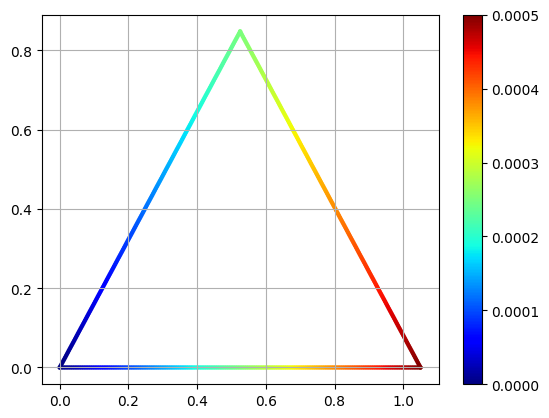

In [88]:
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

dispFigure = plt.figure(1)
ax_dispx = dispFigure.add_subplot(111)
cmap = plt.get_cmap('jet')
ax_dispx.scatter(x_scatter, y_scatter, c=color_x, cmap=cmap, s=10, ec='none');
norm_x = Normalize(np.abs(dispx_array.min()),np.abs(dispx_array.max()))
dispFigure.colorbar(ScalarMappable(norm=norm_x, cmap=cmap))
plt.grid();

## Exercise: 